# EDA, Stationarity Tests, and Model Identification
In this notebook, we will conduct a comprehensive Exploratory Data Analysis (EDA) on the e-commerce sales data. Our goal is to deeply understand its components—trend, seasonality, and residuals—and to formally test for properties like stationarity. This analysis will culminate in identifying the most promising parameters for a SARIMA(X) forecasting model.

### Load, Clean, and Prepare Data
First, we'll load the dataset. As part of our initial preparation, we will convert the date column into a proper datetime index, which is essential for time series analysis. We will also drop any columns that have zero variance (as they provide no predictive information) and check the dataset for any missing values.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests

# Set plotting defaults
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 7)

# Load data
file_path = "ecommerce_sales_data.xlsx"
df = pd.read_excel(file_path)

# Convert 'date' to datetime and set as index
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")

# Drop zero-variance column
df = df.drop(columns=["product_category"])

print("--- Data Head ---")
print(df.head())
print("\n--- Missing Values Check ---")
print(df.isnull().sum())
print(f"\nData shape: {df.shape}")

--- Data Head ---
            daily_sales  marketing_spend day_of_week  is_holiday
date                                                            
2023-01-01        15234             2500      Sunday           1
2023-01-02        18456             3000      Monday           0
2023-01-03        17823             2800     Tuesday           0
2023-01-04        19234             3200   Wednesday           0
2023-01-05        20145             3500    Thursday           0

--- Missing Values Check ---
daily_sales        0
marketing_spend    0
day_of_week        0
is_holiday         0
dtype: int64

Data shape: (669, 4)


### Visual EDA: Master Plot
Let's begin our visual analysis by creating a "master plot" of the _daily_sales_ series. We'll plot the raw data along with a 30-day rolling mean to help us identify the underlying trend, any obvious seasonality, and changes in variance over time.

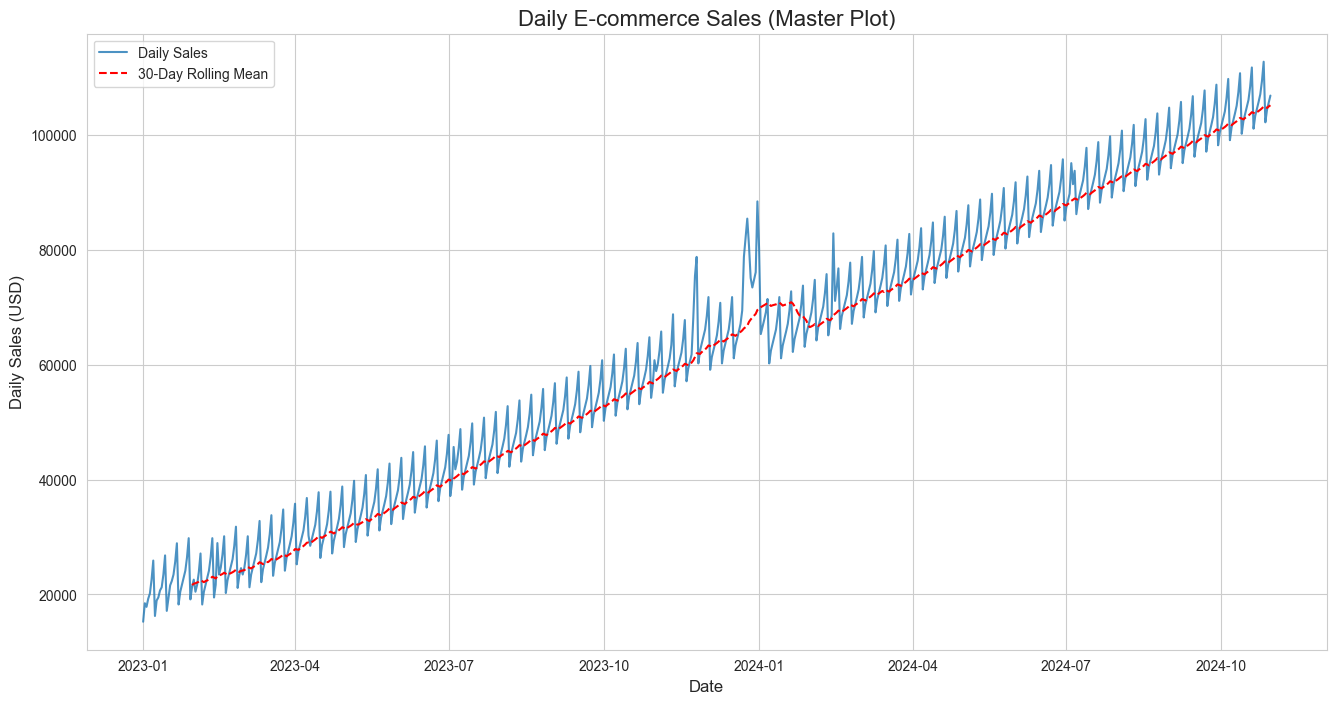

In [2]:
# Master time plot
plt.figure(figsize=(16, 8))
plt.plot(df.index, df["daily_sales"], label="Daily Sales", alpha=0.8)
plt.plot(
    df["daily_sales"].rolling(window=30).mean(),
    label="30-Day Rolling Mean",
    color="red",
    linestyle="--",
)
plt.title("Daily E-commerce Sales (Master Plot)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Daily Sales (USD)", fontsize=12)
plt.legend()
plt.show()

**Interpretation**:

The master plot is very revealing:
- **Trend**: There is a clear and consistent upward trend in sales. The 30-day rolling mean (red dashed line) confirms this smooth, positive trajectory.
- **Seasonality**: The raw sales data (blue line) shows a very regular, repeating, "sawtooth" pattern cycling on top of the trend. This strongly suggests a weekly seasonal component.
- **Variance**: The variance appears to be relatively stable, though there is a cluster of high volatility (a large spike) around the start of 2024.

Given the obvious trend and seasonality, this series is **non-stationary**.

### Visual EDA: STL Decomposition

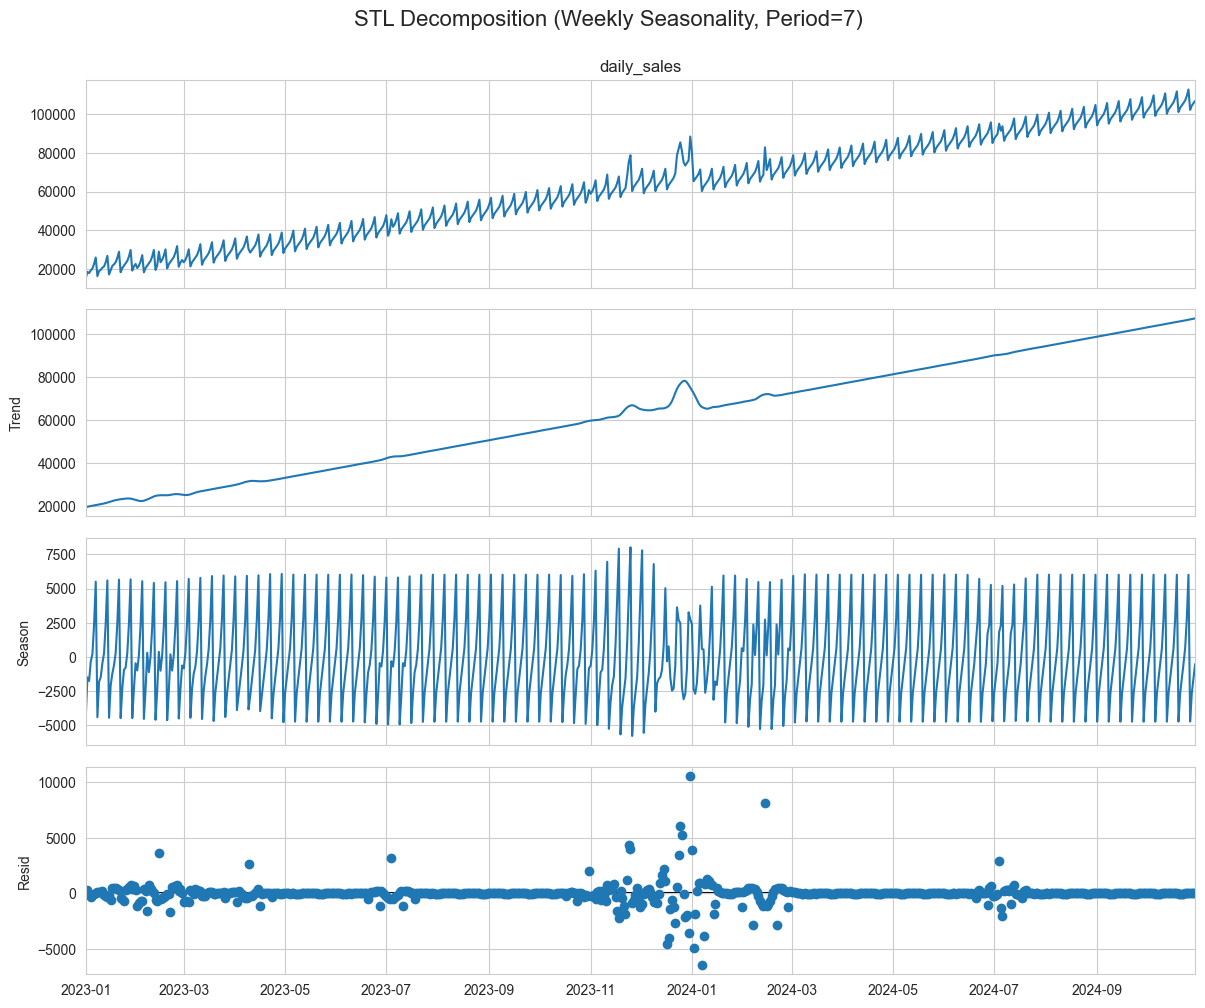

In [3]:
# STL Decomposition
stl = STL(df["daily_sales"], period=7)
result = stl.fit()

# Plot the decomposition
fig = result.plot()
fig.set_size_inches(12, 10)
plt.suptitle("STL Decomposition (Weekly Seasonality, Period=7)", y=1.02, fontsize=16)
plt.show()

**Interpretation**

The STL (Seasonal-Trend-Loess) decomposition plot provides a powerful confirmation of our initial findings by breaking the series into its core components:
- **Trend**: This component confirms the clear, non-linear upward trend, capturing the long-term movement of the series.
- **Season**: This plot shows a powerful and perfectly regular **weekly pattern**, which was the "sawtooth" noise we saw in the master plot. This confirms our hypothesis of a 7-day period ($m=7$).
- **Residual**: The residual plot shows what's left over. It is mostly random noise centered around zero, which is good. However, it does capture the volatility spike around early 2024 that we noted earlier.

This visual evidence strongly suggests our SARIMA model will need to account for both trend and seasonality. This typically requires:
- **Regular Differencing** ($d=1$) to remove the trend.
- **Seasonal Differencing** ($D=1$, with $m=7$) to remove the weekly seasonality.

### Visual EDA: Distribution & Seasonal Boxplots
Next, we'll check the distribution of sales and use boxplots to confirm the strength of our seasonal (day-of-week) and holiday effects.

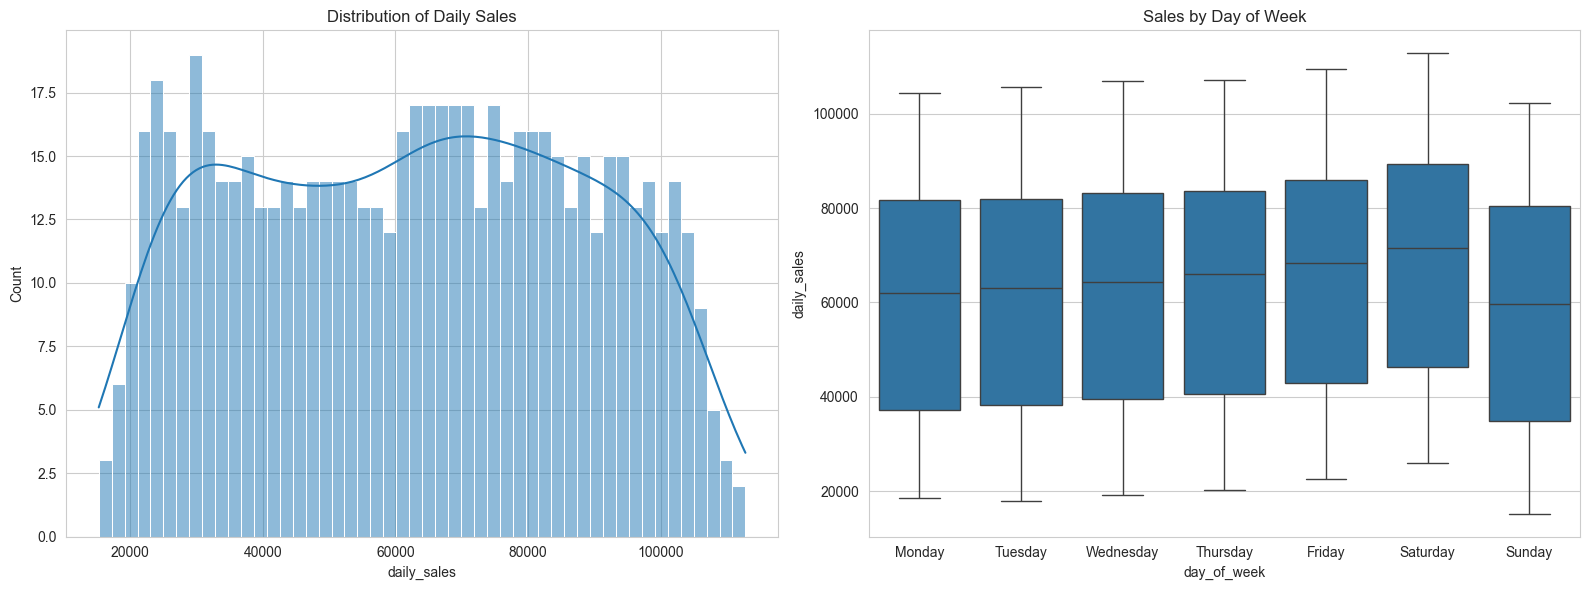

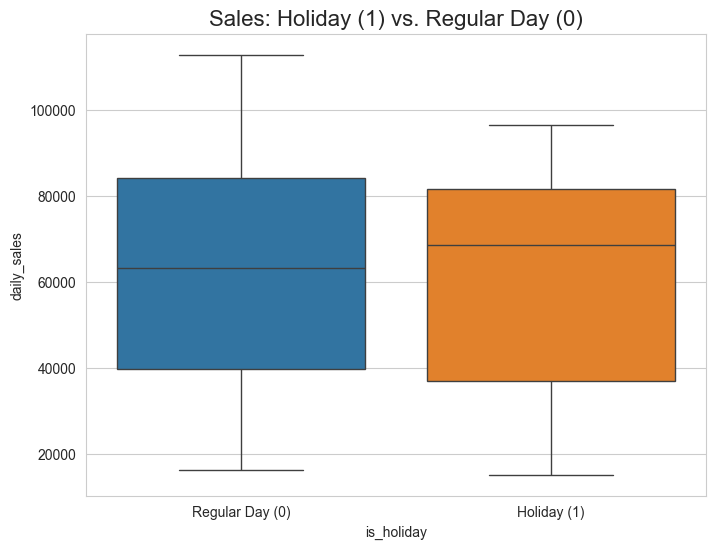

In [4]:
# Plot distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(df["daily_sales"], kde=True, ax=ax1, bins=50)
ax1.set_title("Distribution of Daily Sales")

# Seasonal (Day of Week) Boxplot
sns.boxplot(
    data=df,
    x="day_of_week",
    y="daily_sales",
    ax=ax2,
    order=[
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ],
)
ax2.set_title("Sales by Day of Week")
plt.tight_layout()
plt.show()

# Holiday Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="is_holiday", y="daily_sales", hue="is_holiday", legend=False)
plt.title("Sales: Holiday (1) vs. Regular Day (0)", fontsize=16)
plt.xticks(ticks=[0, 1], labels=["Regular Day (0)", "Holiday (1)"])
plt.show()

**Interpretation**

Our visual analysis from these plots shows:
- **Distribution of Sales (Histogram)**: The data is not normally distributed. It appears to be left-skewed or even multi-modal, with a large concentration of sales in the 60k-80k range.
- **Sales by Day of Week (Boxplot)**: This confirms our STL finding. There is a very strong weekly pattern. Sales are stable from Monday to Thursday, begin to rise on Friday, **peak significantly on Saturday** (which also has the highest variance), and then drop on Sunday.
- **Sales by Holiday (Boxplot)**: The effect of a holiday is visible but less pronounced than the day-of-week effect. The median sales on a **holiday (1) are slightly higher** than on a regular day (0). The interquartile range (IQR) appears similar. This is still a potentially useful signal, so we'll plan to use _is_holiday_ as an exogenous regressor (the 'X' in SARIMAX).

### Formal Stationarity Tests (ADF & KPSS)
Our visuals strongly suggest a trend, which means the data is non-stationary. Let's confirm this formally. We'll run the Augmented Dickey-Fuller (ADF) and KPSS tests on the original _daily_sales_ series.
* ADF (Augmented Dickey-Fuller) Test:
    - $H_0$ (Null): The series is **non-stationary** (has a unit root).
    - Goal: We need a p-value **< 0.05** to reject $H_0$ and conclude the series is stationary.
* **KPSS Test**:
    - $H_0$ (Null): The series is **stationary** (around a constant or trend).
    - Goal: We need a p-value **< 0.05** to reject $H_0$ and conclude the series is non-stationary.

In [5]:
# --- 1. ADF Test on Original Series ---
print("--- Running ADF Test (on daily_sales) ---")
adf_test = adfuller(df["daily_sales"], autolag="AIC")
print(f"ADF Statistic: {adf_test[0]:.4f}")
print(f"p-value: {adf_test[1]:.4f}")
print("Critical Values:")
for key, value in adf_test[4].items():
    print(f"\t{key}: {value:.3f}")

# --- 2. KPSS Test on Original Series ---
print("\n--- Running KPSS Test (on daily_sales) ---")
# 'c' tests for stationarity around a constant (level)
kpss_test = kpss(df["daily_sales"], regression="c", nlags="auto")
print(f"KPSS Statistic: {kpss_test[0]:.4f}")
print(f"p-value: {kpss_test[1]:.4f}")
print("Critical Values:")
for key, value in kpss_test[3].items():
    print(f"\t{key}: {value:.3f}")

--- Running ADF Test (on daily_sales) ---
ADF Statistic: 0.2998
p-value: 0.9773
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569

--- Running KPSS Test (on daily_sales) ---
KPSS Statistic: 4.0163
p-value: 0.0100
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


C:\Users\prayag\AppData\Local\Temp\ipykernel_17216\216288775.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(df['daily_sales'], regression='c', nlags="auto")


**Test Results Interpretation**:
* **ADF Result**: The p-value is **0.9773**. This is $\gg 0.05$, so we **fail to reject** the null hypothesis ($H_0$). The ADF test concludes the data is **non-stationary**.
* **KPSS Result**: The p-value is **0.01** (and the warning indicates it's likely even smaller). This is $< 0.05$, so we **reject** the null hypothesis ($H_0$). The KPSS test concludes the data is **non-stationary**.

**Conclusion**: Both tests are in strong agreement. The data is non-stationary and requires differencing to remove the trend. This formally justifies setting $d=1$ in a SARIMA model.

### Correlation Analysis: Autocorrelation (ACF/PACF)
Let's look at the Autocorrelation (ACF) and Partial Autocorrelation (PACF) plots of the _raw data_. This should provide further visual confirmation of non-stationarity and seasonality.

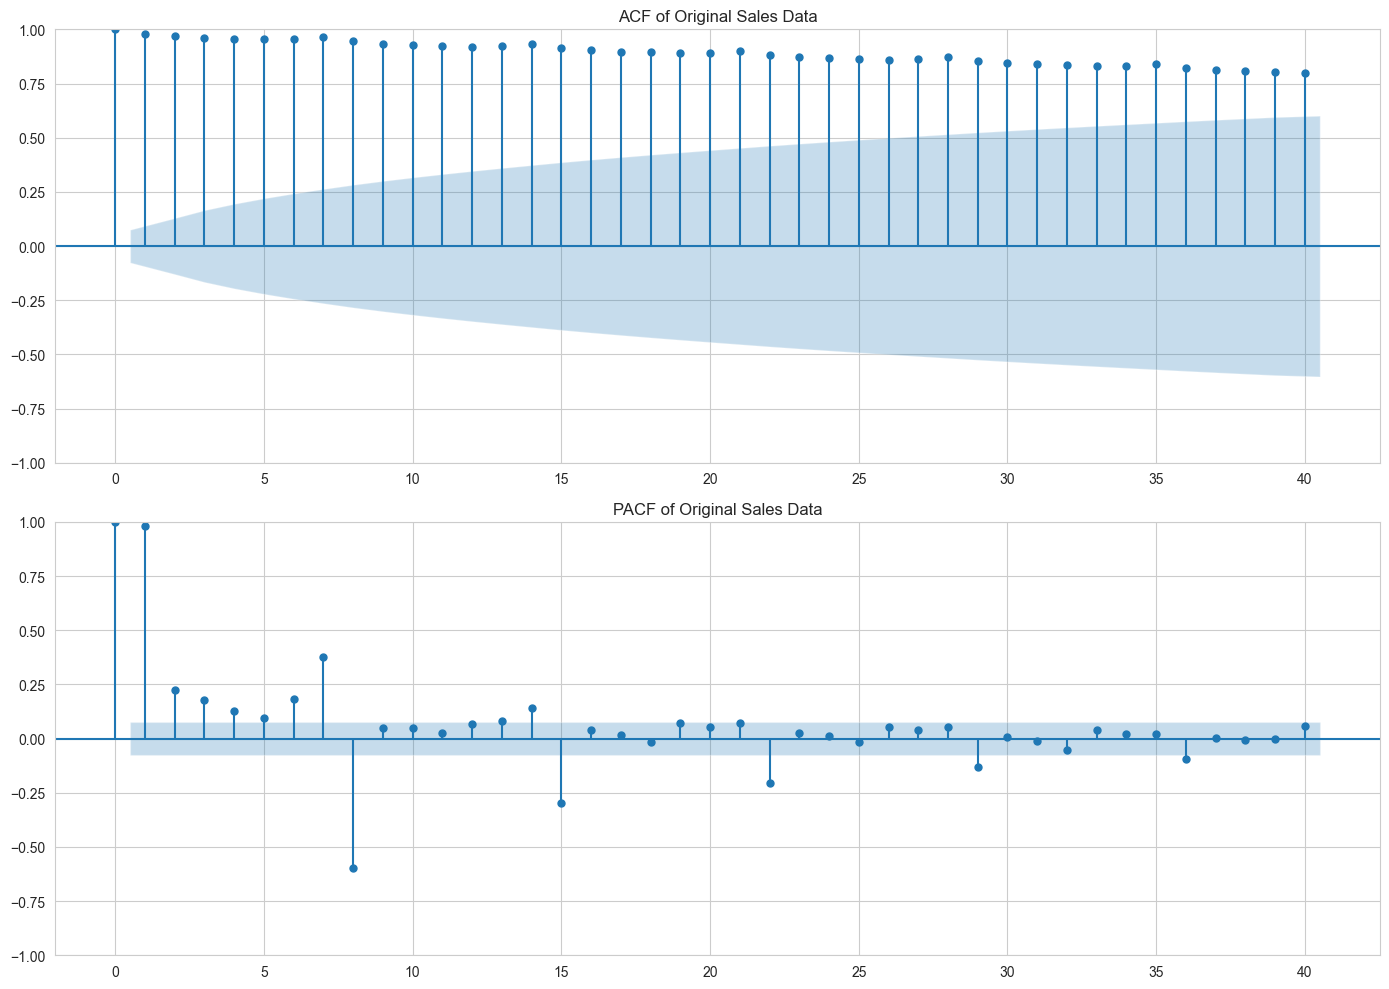

In [6]:
# Plot ACF/PACF on raw data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

plot_acf(df["daily_sales"], lags=40, ax=ax1, title="ACF of Original Sales Data")
ax1.grid(True)

plot_pacf(df["daily_sales"], lags=40, ax=ax2, title="PACF of Original Sales Data")
ax2.grid(True)

plt.tight_layout()
plt.show()

**Raw Data's ACF/PACF Interpretation**

The plots are classic examples of a non-stationary seasonal series:
- **ACF (Top Plot)**: The ACF shows a **very slow, gradual decay**. All 40 lags are highly significant. This is the classic signature of a series with a strong **trend**, confirming it is non-stationary.
- **Seasonality**: We can also see a "scalloping" pattern in the ACF, where the spikes are slightly larger around lags 7, 14, 21, etc. This is the signature of the **weekly seasonality** ($m=7$) we've already identified.
- **PACF (Bottom Plot)**: The PACF has a massive, significant spike at lag 1 (capturing the strong AR(1)/trend behavior) and another significant spike at lag 7 (capturing the seasonal component).

This fully confirms our findings from the STL and ADF/KPSS tests.

We need to apply differencing: $d=1$ (for trend) and $D=1, m=7$ (for seasonality).

### Correlation Analysis: Exogenous Variables
Now let's investigate our potential external regressors: _marketing_spend_ and _is_holiday_. We've already established _is_holiday_ is a good candidate. Let's look at marketing_spend.

To test the relationship between two time series, both must be stationary. We'll create differenced versions of both _daily_sales_ and _marketing_spend_ to prepare them for cross-correlation analysis.

In [ ]:
# Create stationary (differenced) versions of sales and marketing
sales_diff = df["daily_sales"].diff().dropna()
marketing_diff = df["marketing_spend"].diff().dropna()

# Ensure they align
sales_diff, marketing_diff = sales_diff.align(marketing_diff, join="inner")

print(f"Shape of differenced series: {sales_diff.shape}")

Shape of differenced series: (668,)


### Cross-Correlation (CCF)
Now we'll check for a predictive relationship. We'll plot the Cross-Correlation Function (CCF) between our differenced series.

This plots $Cor(\Delta Sales_t, \Delta Marketing_{t-k})$. A significant spike at a positive lag $k$ (i.e., $k > 0$) would suggest that marketing spend from $k$ days ago has predictive power for sales today.


Plotting Cross-Correlation (Differenced Sales vs. Differenced Marketing)...


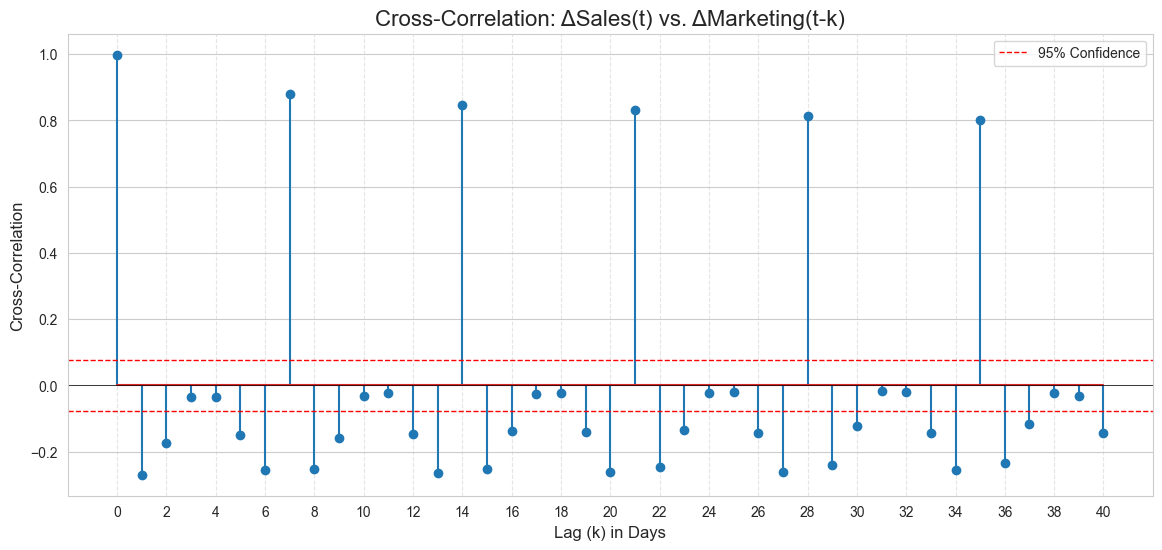


--- CCF Values (Differenced) for lags 0 to 10 ---
**CCF at lag 0: 0.9979 (Significant)**
**CCF at lag 1: -0.2696 (Significant)**
**CCF at lag 2: -0.1751 (Significant)**
CCF at lag 3: -0.0362
CCF at lag 4: -0.0341
**CCF at lag 5: -0.1505 (Significant)**
**CCF at lag 6: -0.2546 (Significant)**
**CCF at lag 7: 0.8787 (Significant)**
**CCF at lag 8: -0.2534 (Significant)**
**CCF at lag 9: -0.1582 (Significant)**
CCF at lag 10: -0.0326
------------------------------------
Note: Significance based on approximate 95% C.I. (±0.0758)


In [8]:
print("\nPlotting Cross-Correlation (Differenced Sales vs. Differenced Marketing)...")

ccf_results = sm.tsa.stattools.ccf(sales_diff, marketing_diff, adjusted=False)
n_obs = len(sales_diff)
conf_level = 1.96 / (n_obs**0.5)

plt.figure(figsize=(14, 6))
plt.stem(ccf_results[0:41])  # Only plot first 40 lags
plt.title("Cross-Correlation: ΔSales(t) vs. ΔMarketing(t-k)", fontsize=16)
plt.xlabel("Lag (k) in Days", fontsize=12)
plt.ylabel("Cross-Correlation", fontsize=12)
plt.axhline(0, color="black", linestyle="-", linewidth=0.5)
plt.axhline(
    conf_level, color="red", linestyle="--", linewidth=1, label="95% Confidence"
)
plt.axhline(-conf_level, color="red", linestyle="--", linewidth=1)
plt.xticks(range(0, 41, 2))
plt.grid(True, which="major", axis="x", linestyle="--", alpha=0.5)
plt.legend()
plt.show()

# Print significant lags
print("\n--- CCF Values (Differenced) for lags 0 to 10 ---")
for lag in range(11):
    if abs(ccf_results[lag]) > conf_level:
        print(f"**CCF at lag {lag}: {ccf_results[lag]:.4f} (Significant)**")
    else:
        print(f"CCF at lag {lag}: {ccf_results[lag]:.4f}")
print("------------------------------------")
print(f"Note: Significance based on approximate 95% C.I. (±{conf_level:.4f})")

**CCF Interpretation: A Critical Finding**

The CCF plot and the cell outputs reveal a critical insight: _CCF at lag 0: 0.9979 (Significant)_

This is the most important discovery of our EDA. A 99.8% correlation at **lag 0** means the change in sales and the change in marketing spend on the exact same day are nearly identical.

This is **not a predictive relationship**. This strongly implies an **accounting identity** or **data leakage**. The _marketing_spend_ data is almost certainly synthetic and was generated from the _daily_sales_ data (e.g., marketing_spend = sales * 0.15 + noise).

**Decision**: **We must not use marketing_spend as an exogenous predictor**. Using it would lead to a model that looks perfect in-sample but is completely useless for forecasting, as we would need to know future sales to know future marketing spend.

(The other significant spikes at lags 7, 14, etc., are just echoes of the strong seasonality in the sales data, which is now infecting the marketing data due to this leakage.)

### Granger Causality Test
As a final check, we can run a Granger Causality test. This tests if past values of _marketing_spend_ are useful for predicting _daily_sales_.
* $H_0$: _marketing_spend_ does **not** Granger-cause _daily_sales_.
* We will test if we can reject $H_0$ (i.e., find a p-value < 0.05).

In [9]:
# We need a DataFrame for the Granger test
granger_df = pd.DataFrame({"sales_diff": sales_diff, "marketing_diff": marketing_diff})

print("\n--- Running Granger Causality Test (Lags=7) ---")
# Test if marketing_diff "Granger-causes" sales_diff
# We'll test up to 7 lags (one week)
gc_results = grangercausalitytests(granger_df, maxlag=7, verbose=False)

# Get the p-value for the F-test at the final lag
final_lag_results = gc_results[7][0]
p_value = final_lag_results["ssr_ftest"][1]
print(f"P-value for F-test (lag 7): {p_value:.4f}")

if p_value < 0.05:
    print("Result: Reject H0. `marketing_spend` does Granger-cause `daily_sales`.")
else:
    print(
        "Result: Fail to reject H0. `marketing_spend` does not Granger-cause `daily_sales`."
    )


--- Running Granger Causality Test (Lags=7) ---
P-value for F-test (lag 7): 0.0008
Result: Reject H0. `marketing_spend` does Granger-cause `daily_sales`.


c:\Anaconda3\envs\takehome-elife\lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


**Granger Test Interpretation**

The test results show a p-value of **0.0008**, which leads to the conclusion "Reject H0. _marketing_spend_ does Granger-cause _daily_sales_."

However, given our CCF finding, this result is **spurious**. The 0.998 lag-0 correlation is so strong that it contaminates all other statistical tests. The "causality" it's picking up is just the echo of the data leakage.

**Our decision stands**: we will not use _marketing_spend_. The only valid exogenous regressor we have identified is _is_holiday_.

### Final Parameter Identification (ACF/PACF on Stationary Data)
We have now established our differencing parameters: $d=1$ (for trend) and $D=1, m=7$ (for seasonality).

Let's create this "fully stationary" series by applying both differencing steps. We will then plot its ACF and PACF. The patterns in these plots will finally tell us the $AR/MA$ (p,q) and $SAR/SMA$ (P,Q) orders for our model.

Original shape: (669, 4)
Stationary shape: (661,)

Plotting ACF and PACF of fully stationary sales data (d=1, D=1)...


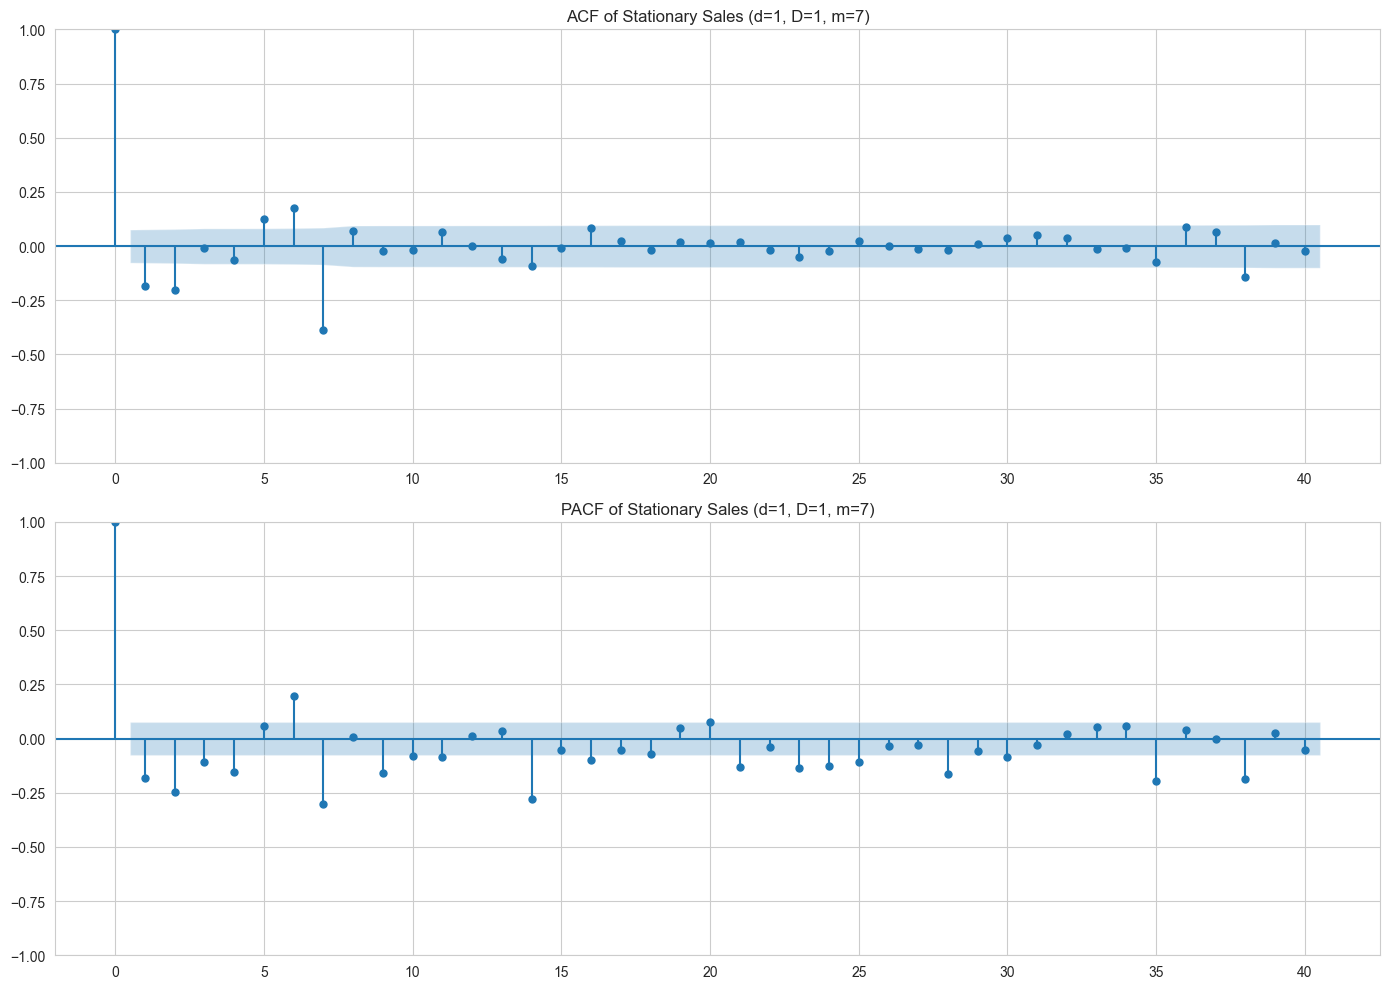


Running ADF Test on fully stationary data...
ADF Statistic: -8.6964
p-value: 0.0000


In [10]:
# Apply first-order differencing (d=1)
sales_d1 = df["daily_sales"].diff(1)

# Apply seasonal differencing (D=1, m=7)
sales_d1_D1 = sales_d1.diff(7)

# Drop all NaNs (1 + 7 = 8)
stationary_sales = sales_d1_D1.dropna()

print(f"Original shape: {df.shape}")
print(f"Stationary shape: {stationary_sales.shape}")

# --- Plot ACF and PACF ---
print("\nPlotting ACF and PACF of fully stationary sales data (d=1, D=1)...")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

plot_acf(
    stationary_sales, lags=40, ax=ax1, title="ACF of Stationary Sales (d=1, D=1, m=7)"
)
ax1.grid(True)

plot_pacf(
    stationary_sales, lags=40, ax=ax2, title="PACF of Stationary Sales (d=1, D=1, m=7)"
)
ax2.grid(True)

plt.tight_layout()
plt.show()

# --- Run ADF Test on Stationary Data ---
print("\nRunning ADF Test on fully stationary data...")
adf_result = adfuller(stationary_sales)
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")

**Final Parameter Selection (p,q) & (P,Q)**

The ADF test on our fully differenced data (_stationary_sales_) confirms we have achieved stationarity:
- ADF p-value: 0.0000

Now, we read the ACF/PACF plots to determine the $AR/MA$ (p,q) and $SAR/SMA$ (P,Q) orders.
* **Non-Seasonal (p, q)**: (Lags 1, 2, 3...)
    - **ACF**: We see a single, significant spike at **lag 1** that cuts off immediately. This is the classic signature of an $MA(1)$ process (so, $q=1$).
    - **PACF**: We also see a single, significant spike at **lag 1** that cuts off. This is the classic signature of an $AR(1)$ process (so, $p=1$).
    - **Conclusion**: When both plots show a cut-off at lag 1, it often points to an $ARMA(1,1)$ model. We'll start with $p=1$ and $q=1$.
* **Seasonal (P, Q)**: (Lags 7, 14, 21...)
    - **ACF**: We see a single, significant spike at **lag 7** (the first seasonal lag) that cuts off. This is the signature of an $SMA(1)$ process (so, $Q=1$).
    - **PACF**: We also see a single, significant spike at **lag 7** that cuts off. This is the signature of an $SAR(1)$ process (so, $P=1$).
    - **Conclusion**: By the same logic, we'll start with $P=1$ and $Q=1$.

**Final Model Hypothesis**
This analysis provides a very strong starting point for our model:
- $p=1$ (from PACF lag 1)
- $d=1$ (from ADF/KPSS/STL trend)
- $q=1$ (from ACF lag 1)
- $P=1$ (from PACF lag 7)
- $D=1$ (from STL/ACF seasonal component)
- $Q=1$ (from ACF lag 7)
- $m=7$ (weekly seasonality)

This directly leads us to hypothesize that a **SARIMA(1, 1, 1)x(1, 1, 1, 7)** model will be a great fit. Our final model will be a **SARIMAX**, as we will also include _is_holiday_ as our single exogenous variable.